In [142]:
import pickle 
import os    
import re
import pandas as pd
import string
from string import *
from additional_stopwords import ADDITIONAL_STOPWORDS
from nltk.corpus import stopwords



In [143]:
CHAT_DIR = os.getcwd() + "/chats/"
USER_PATTERN = r'- ([^:]+): (.+)'
LINK_PATTERN = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'
LAUGH_PATTERN = r'\b(?:\w*(?:k\w?k)+\w*?)\b'

EMOJI_PATTERN = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


STOP_WORDS = set(stopwords.words('portuguese') + list(punctuation) + list(ADDITIONAL_STOPWORDS))


In [144]:
def get_data_by_chat(chat_names_list):
    data_chats = {}
    for chat_name in chat_names_list:
        if chat_name.startswith("."): continue
        data_chats[chat_name] = organize_phrases_by_users(f'{CHAT_DIR}{chat_name}')
    return data_chats



In [145]:
def organize_phrases_by_users(file_path):      
    chat_regex = re.compile(USER_PATTERN) 
    users_dict = {}
    with open(file_path, "r") as file:
        chat_lines = file.read().splitlines()
        last_user = ""
        for line in chat_lines:
            match = chat_regex.search(line)
            if match is None:
                users_dict[last_user].append(line)
                continue

            user, phrase = match.groups()
            if users_dict.get(user) is None:
                users_dict[user] = []
                continue
            
            users_dict[user].append(phrase)

            last_user = user
    return users_dict
             

        

In [146]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

In [147]:
chat_names_list = os.listdir(CHAT_DIR)
data_chats = get_data_by_chat(chat_names_list)

for chat, users in data_chats.items():
    data_chats[chat] = { key: [combine_text(value)] for (key, value) in users.items() }

In [148]:
pd.set_option('max_colwidth', 150)
data_chats_frame = pd.concat({ key: pd.DataFrame(value).T for key, value in data_chats.items() }, axis=0)

data_chats_frame.columns = ['chats']
data_chats_frame.chats.dropna(inplace=True)


In [149]:

import emoji

def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\<.*?\>', '', text)
    text = re.sub(LINK_PATTERN, '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(LAUGH_PATTERN, '', text)
    #text = remove_emoji(text)
    text = re.sub('\s\s+', ' ', text)
    text = re.sub("[‘’“”…']", '', text)
    text = re.sub('\n', '', text)
    return text

lambda_round1 = lambda text: clean_text_round1(text)


In [150]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_chats_frame.chats.apply(lambda_round1))


In [151]:
import nltk
#download if not downloaded
#nltk.download()

In [152]:
from nltk.tokenize import word_tokenize

only_words_data_frame = pd.DataFrame(data_clean.chats.apply(word_tokenize))

only_words_data_frame


chats
chat1.txt Caio Farias  [imagina, caramba, toma, cuidado, descansa, visse, namroal, bota, um, fonezao, alto, e, relaxa, aí, é, tenso, vei, mais, uma, pedra, no, caminho, ...
          Letícia      [tô, muito, cansada, 🤦🏻‍♀, fui, dormir, cedo, mas, ainda, tô, cansada, como, com, a, minha, casa, em, reforma, fica, difícil, o, problema, nem, é,...
chat2.txt Vou não vei  [mito, mito, das, matrizes, e, das, determinantes, 👨🏻‍💻☕, programaio, com, cafaio, oq, é, bom, programaio, com, cafaio, ou, isso, amanhã, ou, sext...
          Caio Farias  [é, bom, ne, isso, aí, s, vou, falar, com, ele, é, de, boa, po, vai, de, la, é, mais, fácil, pra, tu, eu, vejo, com, meu, pai, aq, beleza, ele, ai...

In [153]:
from string import punctuation

def remove_stopwords(array_of_words):
    return [word for word in array_of_words if word not in STOP_WORDS]

final_data_df = pd.DataFrame(only_words_data_frame.chats.apply(remove_stopwords))



In [154]:
from nltk.probability import FreqDist

get_most_common = lambda x: dict(FreqDist(x).most_common(200))
frequency_df = pd.DataFrame(final_data_df.chats.apply(get_most_common))


In [155]:

from collections import Counter

##Get most common words between users and exclude them

words = []
for chat, user in final_data_df.chats.items():
    top_words_user_tuple = Counter(user).most_common(30) 
    top_words_user_list = [word for (word, count) in top_words_user_tuple]
    for t in top_words_user_list:
        words.append(t)

add_stop_words = [word for word, count in Counter(words).most_common() if count > 3]
add_stop_words




['vai',
 'aí',
 'vou',
 'tô',
 'pq',
 'tá',
 'tbm',
 'sim',
 'boa',
 'sei',
 'acho',
 'né',
 'ainda',
 'lá']

In [156]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

##Setup wordclouds

print(add_stop_words)
wc = WordCloud(stopwords=STOP_WORDS.union(add_stop_words), background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [20, 20]

['vai', 'aí', 'vou', 'tô', 'pq', 'tá', 'tbm', 'sim', 'boa', 'sei', 'acho', 'né', 'ainda', 'lá']


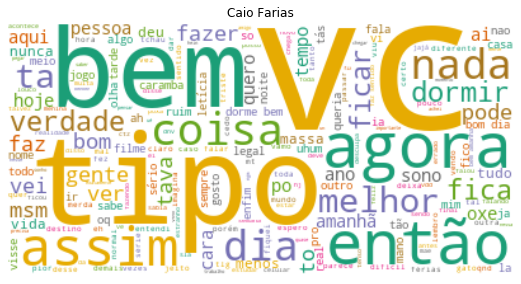

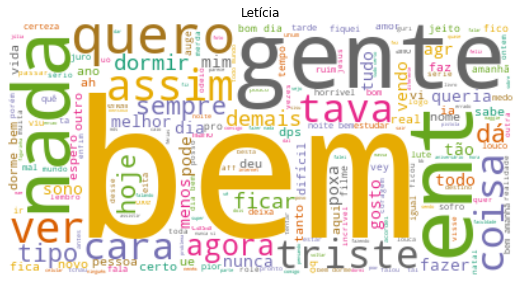

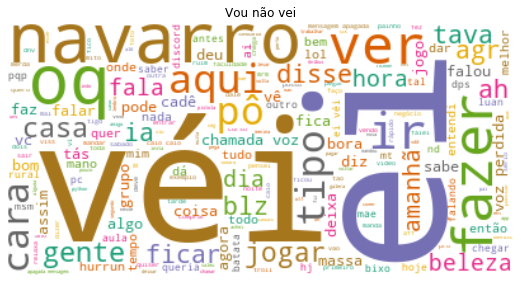

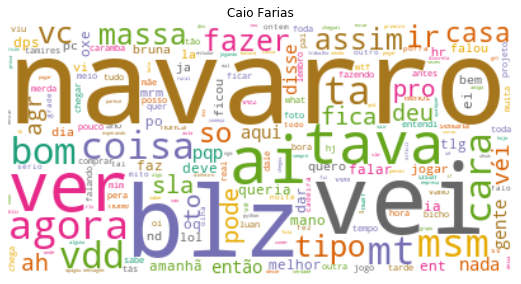

In [157]:
#Create wordclouds
for index, (chat, user) in enumerate(final_data_df.chats.items()):    
    wc.generate(" ".join(user))
    plt.subplot(3,2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(chat[1])
    plt.show()

(array([    0,     1,     2, ..., 56910, 56911, 56912]),)
(array([    0,     1,     2, ..., 54412, 54413, 54414]),)
(array([    0,     1,     2, ..., 19723, 19724, 19725]),)
(array([    0,     1,     2, ..., 11691, 11692, 11693]),)
[56913, 54415, 19726, 11694]
